# Optimized k-means clustering 

(python version)

<strong>Shanshan Wang</strong>\
<strong>shanshan.wang@uni-due.de</strong>

## Table of Contents
<div class="alert alert-block alert-info" style="margin-top: 20px">

<ol>
<li><a href="#data">Load data</a></li>
<li><a href="#define">Define functions</a></li>
<li><a href="#set">Set parameters</a></li>
<li><a href="#kmeans"> K-means clustering</a> </li>
<li><a href="#before"> Before opitimzation</a> </li>
<li><a href="#after"> After opitimzation</a> </li>
<li><a href="#reference">Reference</a> </li>
</ol>
    
</div>

In [1]:
import pandas as pd
import numpy as np
import scipy.io as sio
import seaborn as sns
from numpy import linalg as LA
from numpy import inf
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy.matlib

### <a name="data"></a>Load data

In [2]:
# load the reduced-rank correlation matrix of the NRW motorway network for workdays
# the reduced-rank correlation matrix should be symmetric
Mat=sio.loadmat("redcorr_workday.mat")['redcorr_workday']


<AxesSubplot:>

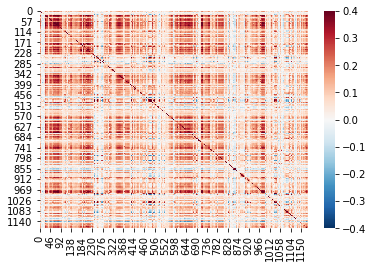

In [3]:
sns.heatmap(Mat, cmap="RdBu_r", vmin=-0.4, vmax=0.4)

### <a name='define'></a>Define functions

In [4]:
def UsedEigVector(Mat,K):
    M=Mat;
    M[M == inf] = 0
    M=np.nan_to_num(M)
    # D contains eigenvalues, V contains the corresponding eigenvectors
    D, V = LA.eig(Mat)
    # eigenvalues in D is sorted from large to small 
    # use K-1 eigenvectors corresponding to K-1 largest eigenvalues for clustering
    U=V[:,0:K-1]; 
    return U

In [5]:
def PlotSilhouette(X,n_clusters,cluster_labels):
    fig, ax = plt.subplots(1, 1)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels,metric='euclidean')
    # The silhouette_score gives the average value for all the samples.
    silhouette_avg = silhouette_score(X, cluster_labels, metric='euclidean')
    y_lower = 10
    for i in range(1,n_clusters+1):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("")
    ax.set_xlabel("Silhouette Value")
    ax.set_ylabel("Cluster")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


In [6]:
def OptimizeCluster(U,clusteridx,K):
    sil = silhouette_samples(U,clusteridx,metric='euclidean')
    # assign the observations with negative silhouette to an additional cluster K+1
    clusteridx[sil<0]=K+1;
    ii=0;
    while ii<K+1:
        ii=ii+1;
        negsilidx=np.argwhere(clusteridx==K+1);
        for i in range(len(negsilidx)):
            asil=[];
            for k in range(1,K+2,1):
                # assign the observations in cluster K+1 to each cluster and calculate
                # silhouette value for each case
                clusteridx[negsilidx[i]]=k;
                # calcualte silhouette values for all points
                sil0 = silhouette_samples(U,clusteridx,metric='euclidean')
                asil.append(sil0[negsilidx[i]]);
                del sil0
            
            # find the cluster which results in the maximal silhouette value
            # for the observation with index negsilidx(i)
            j=np.argmax(asil);
            # assign the observation to the above cluster
            clusteridx[negsilidx[i]]=j+1;
            del j
        
        del sil 
        del negsilidx
        # calcualte silhouette values for all observations
        sil = silhouette_samples(U,clusteridx,metric='euclidean')
        # assign the points with negative silhouette to cluster K+1
        clusteridx[sil<0]=K+1;
    
    return clusteridx

### <a name="set"></a>Set parameters 

In [7]:
K=4 # number of clusters
randnum=437 # random seed

### <a name="kmeans"></a> K-means clustering

In [8]:
# spectral information
U=UsedEigVector(Mat,K)
# k-means clustering
kmeans = KMeans(init="k-means++",n_clusters=K, max_iter=100,n_init=10,random_state=randnum).fit(U)
# cluster number is from 1 to K
clusteridx=kmeans.labels_+1
np.unique(clusteridx)

array([1, 2, 3, 4], dtype=int32)

### <a name="before"></a>Before optimization

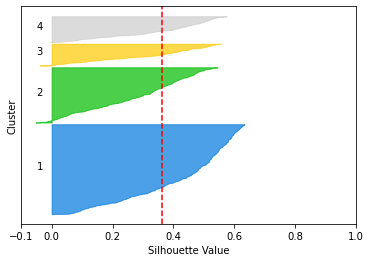

In [9]:
# before optimization
PlotSilhouette(U,K,clusteridx)

### <a name="after"></a>After optimization

In [10]:
# optimize clusters
clusteridx=OptimizeCluster(U,clusteridx,K)
np.unique(clusteridx)

array([1, 2, 3, 4, 5], dtype=int32)

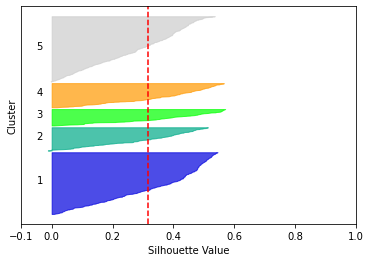

In [11]:
# after optimization
PlotSilhouette(U,K+1,clusteridx)

###  <a name='reference'></a>Reference
Shanshan Wang, Michael Schreckenberg and Thomas Guhr, Identifying subdominant collective effects in a large motorway network, J. Stat. Mech. (2022) 113402 [https://doi.org/10.1088/1742-5468/ac99d4](https://doi.org/10.1088/1742-5468/ac99d4)


